# **Stock Price Prediction**

In [4]:
# Import necessary libraries
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

---
## Data Loading and Preprocessing
---

In [5]:
# Download stock data
ticker = 'AAPL'  # Apple stock
start_date = '2010-01-01'
end_date = '2023-01-01'

data = yf.download(ticker, start=start_date, end=end_date)

# Display first few rows
print("First few rows of the dataset:")
display(data.head())

# Basic information about the dataset
print("\nDataset information:")
data.info()

# Statistical summary
print("\nStatistical summary:")
display(data.describe())

/tmp/ipython-input-5-140288611.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

First few rows of the dataset:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431898,6.446624,6.382909,6.414466,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340532,6.468563,6.333920,6.443017,552160000
2010-01-07,6.328810,6.371488,6.282827,6.363974,477131200
2010-01-08,6.370887,6.371488,6.283129,6.320396,447610800



Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2010-01-04 to 2022-12-30
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   3272 non-null   float64
 1   (High, AAPL)    3272 non-null   float64
 2   (Low, AAPL)     3272 non-null   float64
 3   (Open, AAPL)    3272 non-null   float64
 4   (Volume, AAPL)  3272 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 153.4 KB

Statistical summary:


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
count,3272.000000,3272.000000,3272.000000,3272.000000,3.272000e+03
mean,48.837106,49.361432,48.273689,48.813946,2.562707e+08
std,47.212410,47.790601,46.591677,47.184467,2.225648e+08
min,5.771909,5.890620,5.717810,5.781523,3.519590e+07
25%,16.413693,16.600554,16.281291,16.413012,1.023541e+08
50%,27.036164,27.251460,26.903466,27.095793,1.666698e+08
75%,54.250730,54.928157,53.858814,54.404442,3.456643e+08
max,178.645630,179.558504,175.809106,179.254237,1.880998e+09


---
## Exploratory Data Analysis (EDA)
---

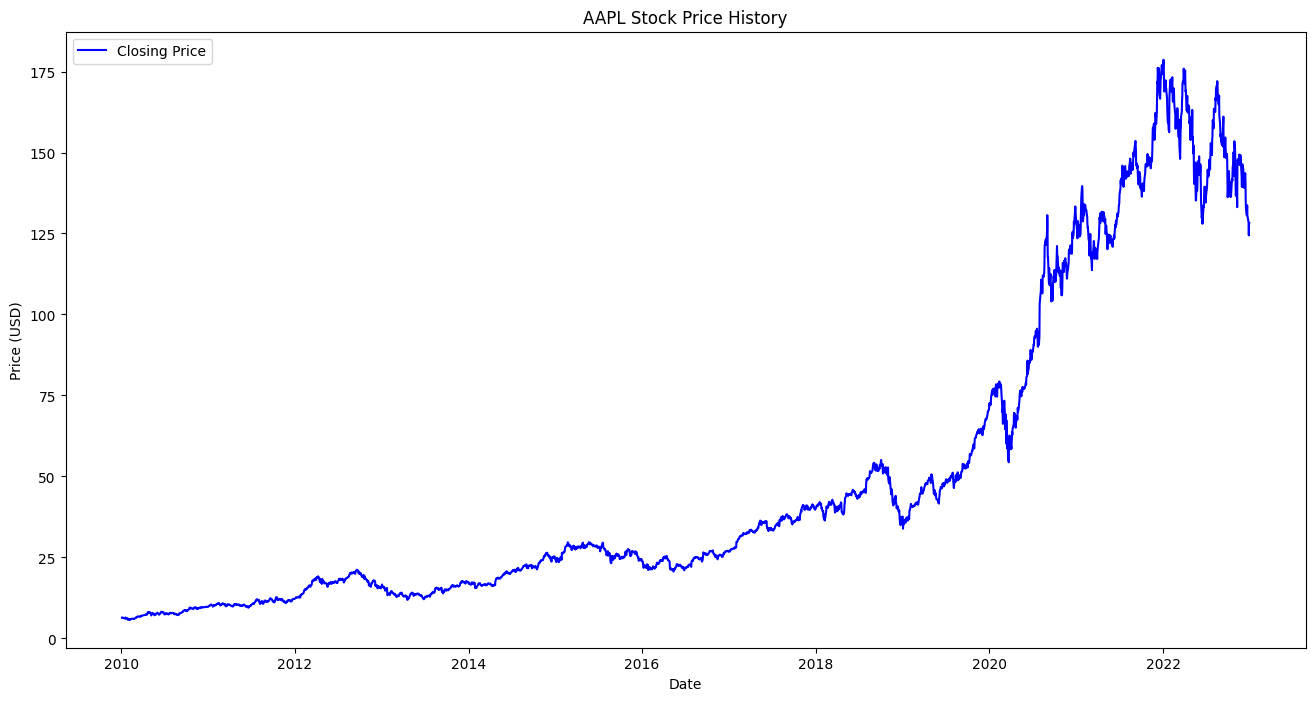

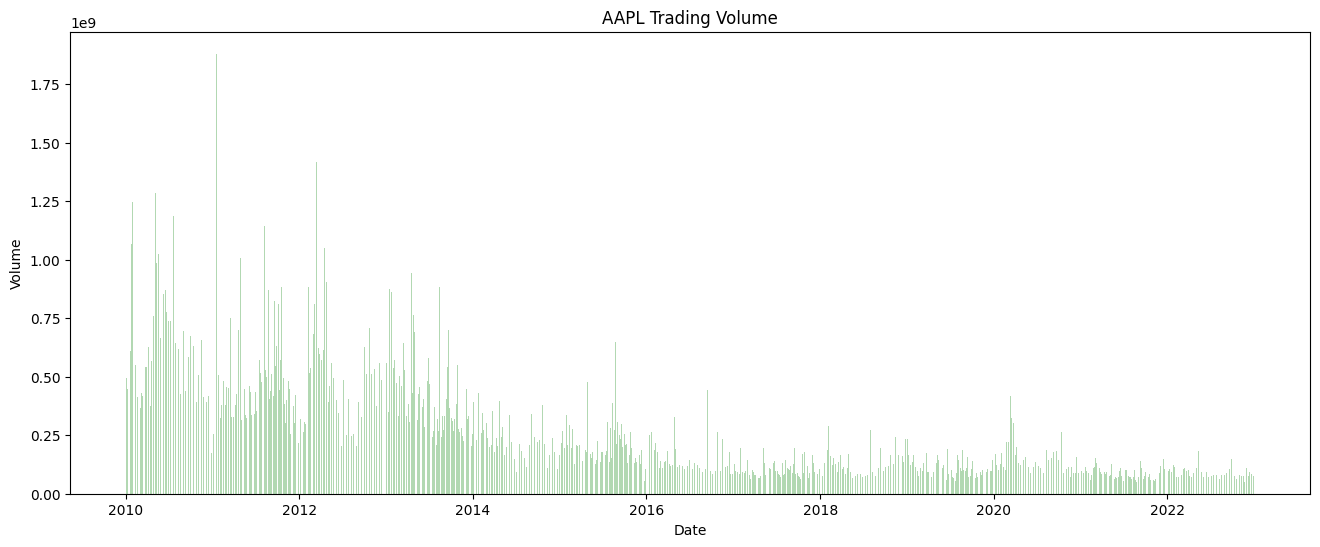

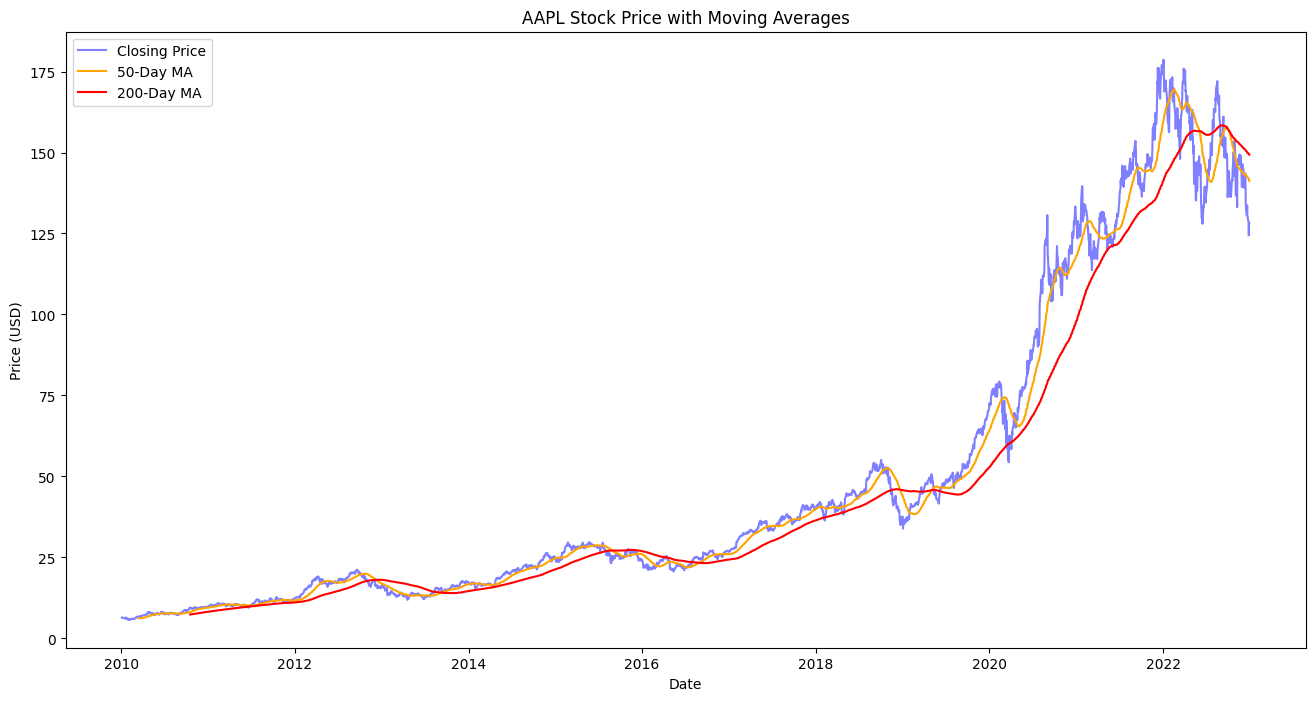

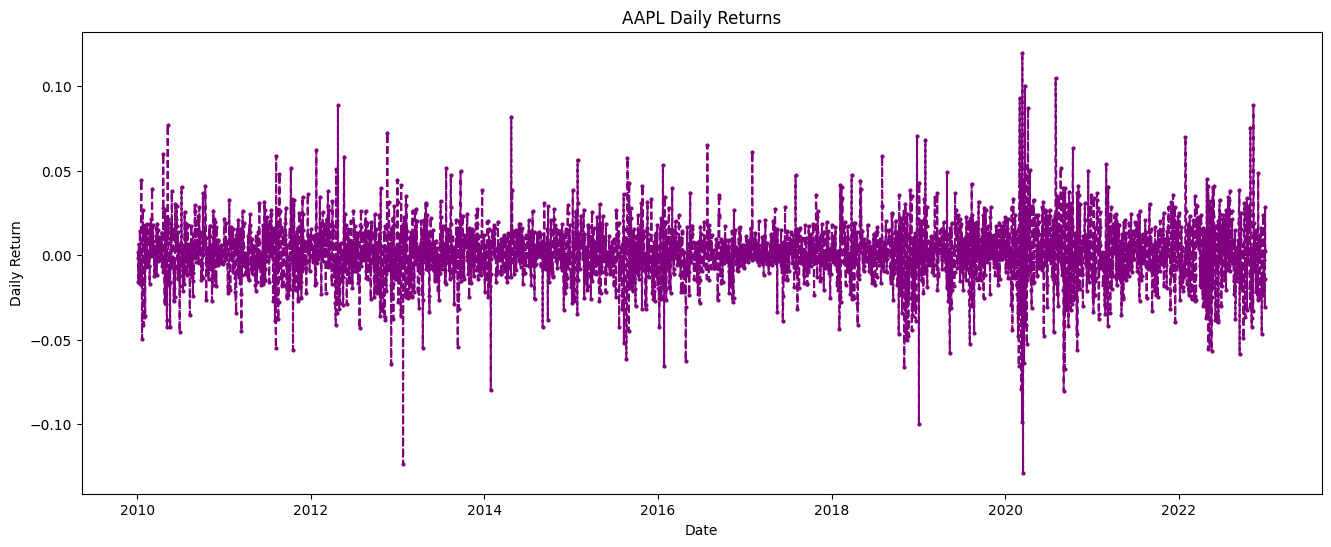

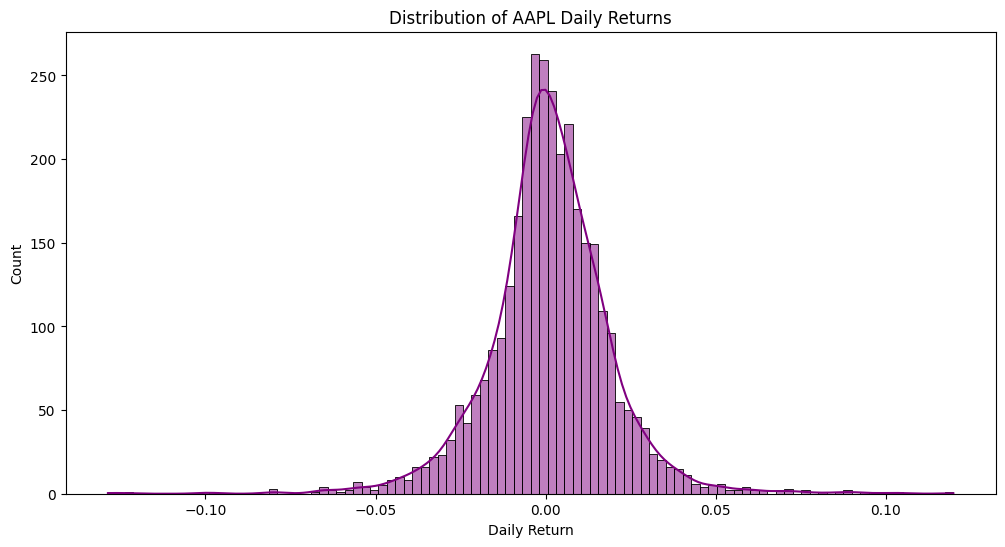

In [7]:
# Plot closing price history
plt.figure(figsize=(16, 8))
plt.plot(data['Close'], label='Closing Price', color='blue')
plt.title(f'{ticker} Stock Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Flatten column names
data.columns = ['_'.join(col).strip() for col in data.columns.values]

# Plot volume
plt.figure(figsize=(16, 6))
plt.bar(data.index, data['Volume_AAPL'], color='green', alpha=0.3)
plt.title(f'{ticker} Trading Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

# Moving averages
data['MA50'] = data['Close_AAPL'].rolling(window=50).mean()
data['MA200'] = data['Close_AAPL'].rolling(window=200).mean()

plt.figure(figsize=(16, 8))
plt.plot(data['Close_AAPL'], label='Closing Price', color='blue', alpha=0.5)
plt.plot(data['MA50'], label='50-Day MA', color='orange')
plt.plot(data['MA200'], label='200-Day MA', color='red')
plt.title(f'{ticker} Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Daily returns
data['Daily Return'] = data['Close_AAPL'].pct_change()

plt.figure(figsize=(16, 6))
plt.plot(data['Daily Return'], color='purple', linestyle='--', marker='o', markersize=2)
plt.title(f'{ticker} Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

# Distribution of daily returns
plt.figure(figsize=(12, 6))
sns.histplot(data['Daily Return'].dropna(), bins=100, color='purple', kde=True)
plt.title(f'Distribution of {ticker} Daily Returns')
plt.show()

---
## Data Preparation for LSTM
---

In [9]:
# Create a new dataframe with only the 'Close' column
close_data = data.filter(['Close_AAPL'])

# Convert to numpy array
dataset = close_data.values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create training data (80% of the data)
training_data_len = math.ceil(len(dataset) * 0.8)

# Create the scaled training data set
train_data = scaled_data[0:training_data_len, :]

# Split into x_train and y_train
x_train = []
y_train = []

# Use 60 days as lookback window
lookback = 60

for i in range(lookback, len(train_data)):
    x_train.append(train_data[i-lookback:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

---
## Build and Train LSTM Model
---

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - loss: 0.0016 - val_loss: 2.8137e-04
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 9.0897e-05 - val_loss: 2.8138e-04
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 8.7754e-05 - val_loss: 2.4018e-04
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 6.5778e-05 - val_loss: 2.3337e-04
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 5.3484e-05 - val_loss: 2.6296e-04
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 4.8197e-05 - val_loss: 2.1091e-04
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 4.8834e-05 - val_loss: 2.0170e-04
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 5.6905e-05 - val_loss: 1.8514e-04
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 5.5779e-05 - val_loss: 1.7814e-04
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.6453e-05 - val_loss: 1.8290e-04
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 4

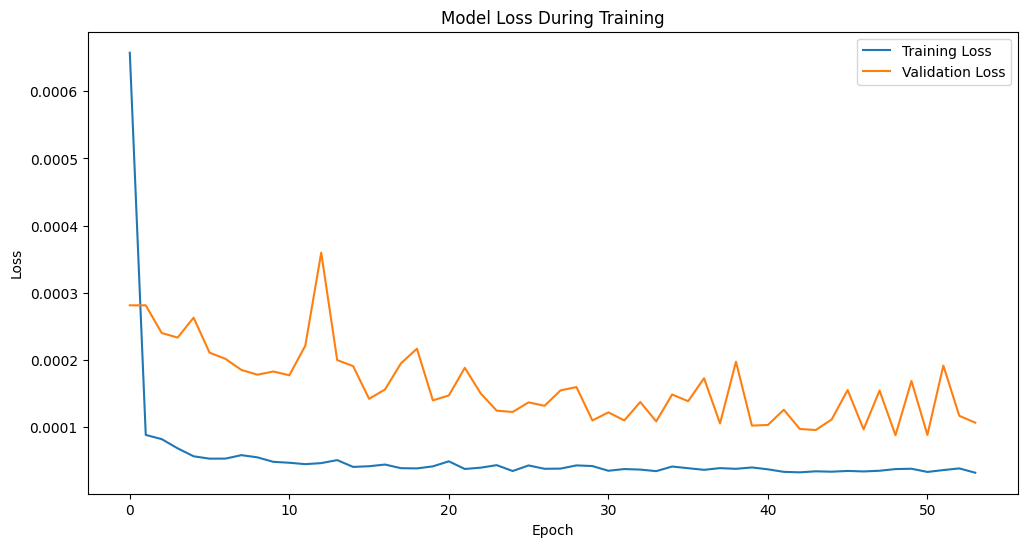

In [10]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---
## Model Evaluation
---

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Root Mean Squared Error (RMSE): 4.20
Mean Absolute Error (MAE): 3.22
R-squared (R2) Score: 0.9633


/tmp/ipython-input-12-2221468521.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


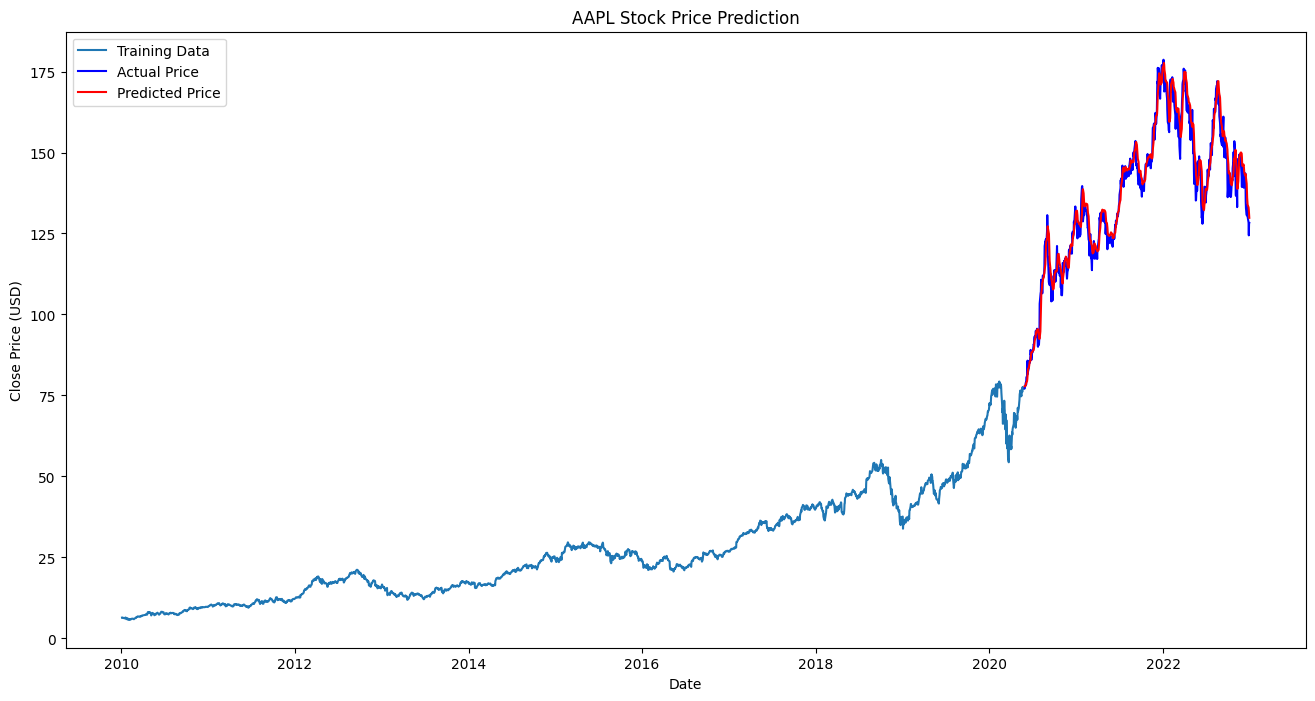

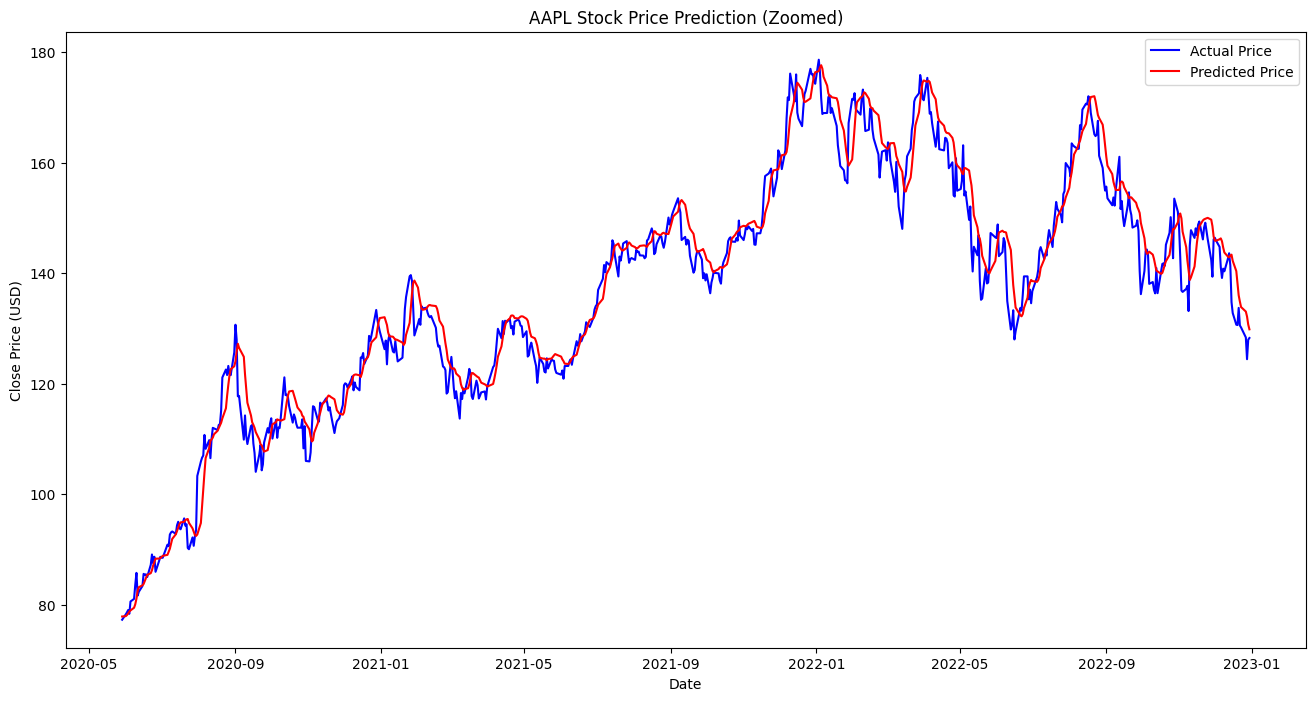

In [12]:
# Create the testing data set
test_data = scaled_data[training_data_len - lookback:, :]

# Create x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(lookback, len(test_data)):
    x_test.append(test_data[i-lookback:i, 0])

# Convert to numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the model's predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R2) Score: {r2:.4f}")

# Plot the predictions vs actual values
train = close_data[:training_data_len]
valid = close_data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(train['Close_AAPL'], label='Training Data')
plt.plot(valid['Close_AAPL'], label='Actual Price', color='blue')
plt.plot(valid['Predictions'], label='Predicted Price', color='red')
plt.legend()
plt.show()

# Plot the predictions vs actual values (zoomed in)
plt.figure(figsize=(16, 8))
plt.title(f'{ticker} Stock Price Prediction (Zoomed)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(valid['Close_AAPL'], label='Actual Price', color='blue')
plt.plot(valid['Predictions'], label='Predicted Price', color='red')
plt.legend()
plt.show()

---
## Future Price Prediction
---

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

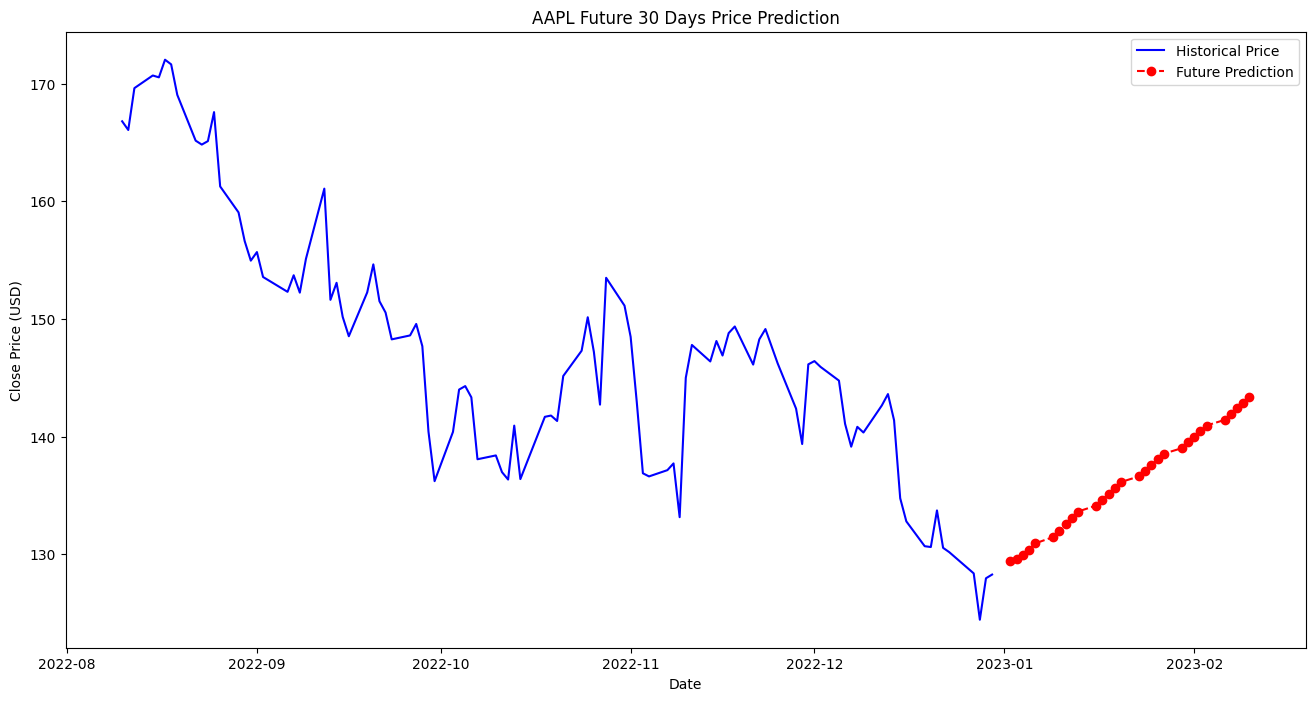

In [14]:
# Function to predict future prices
def predict_future_prices(model, last_sequence, scaler, days=30):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Reshape the current sequence for prediction
        current_sequence_reshaped = np.reshape(current_sequence, (1, current_sequence.shape[0], 1))

        # Get the prediction
        next_pred = model.predict(current_sequence_reshaped)

        # Append the prediction to future predictions
        future_predictions.append(next_pred[0, 0])

        # Update the current sequence
        current_sequence = np.append(current_sequence[1:], next_pred)

    # Inverse transform the predictions
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

# Get the last sequence from the test data
last_sequence = test_data[-lookback:, 0]

# Predict next 30 days
future_days = 30
future_predictions = predict_future_prices(model, last_sequence, scaler, future_days)

# Create future dates
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='B')

# Plot the future predictions
plt.figure(figsize=(16, 8))
plt.title(f'{ticker} Future {future_days} Days Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.plot(data.index[-100:], data['Close_AAPL'].values[-100:], label='Historical Price', color='blue')
plt.plot(future_dates, future_predictions, label='Future Prediction', color='red', linestyle='--', marker='o')
plt.legend()
plt.show()